In [2]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [20]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
t0_utc="2023-05-18T12:59:08.000000" # hard x-ray
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
rt=1
# nrt=1
arc=0
required_completeness=0.6
mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [21]:
t0_utc

'2023-05-18T12:59:08.000000'

In [22]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [23]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [24]:
import importlib

In [25]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [26]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

2023-05-18 16:07:20 savchenk-NG-VN7-793G-79EG root[604113] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-18T16:07:20/IJD
2023-05-18 16:07:21 savchenk-NG-VN7-793G-79EG root[604113] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-18T12:59:08.000000/IJD


(8538.67256, 8538.541865555555, 8538.538393333332, 8538.545337777778)

In [27]:
lcs={}


In [28]:
if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    
    lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    lcs['ACS'][:,1] = 0.05
    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-05-18T12:59:08.000000/300


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/isdcclient.py:65: ConversionWarning: Some errors were detected !
    Line #2 (got 11 columns instead of 13)
    Line #3 (got 11 columns instead of 13)
    Line #4 (got 14 columns instead of 13)
    Line #5 (got 11 columns instead of 13)
    Line #6 (got 11 columns instead of 13)
  return np.genfromtxt(BytesIO(lc_raw.replace(b"\\n", b"").replace(b"<br>", b"")), invalid_raise=False)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [12]:
import re
import time

# if rt == 1:

#     got_data = False
    
#     while not got_data:
#         current_rev=float(ic.converttime("UTC",t0_utc,"REVNUM"))

#         print("current rev", current_rev)

#         rtdata_roots=[
#             '/unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',
#             '/rtdata',
#             '/mnt/sshfs/isdc-in01//unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',    
#         ]

#         for realtime_dump_root in rtdata_roots + [ None ]:
#             #print("probing",realtime_dump_root,"with",glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))
#             if realtime_dump_root and len(glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))>0:
#                 print("this",realtime_dump_root)
#                 break

#         if not realtime_dump_root:
#             raise Exception("no realtime archvie found")

#         for rt_fn in reversed(sorted([l for l in glob.glob(realtime_dump_root+"/lcdump-revol-*.csv") if 
#                        float(re.search("lcdump-revol-(\d{4}).*.csv",l).groups()[0])<=current_rev+1])):

#             print(rt_fn)

#             rt_lc = np.genfromtxt(rt_fn)

#             lcs['ACS']=rt_lc[:,(3,0,2,0)]
#             lcs['ACS'][:,1] = 0.05

#             first_data = lcs['ACS'][:,0][0]
#             last_data = lcs['ACS'][:,0][-1]

#             print("now", now_ijd, 
#                   "first data in file", first_data, 
#                   "last data", last_data, 
#                   "requested", t0_ijd, 
#                   "have margin", (last_data-t0_ijd)*24*3600,"s",
#                   "data delay", (now_ijd-last_data)*24*3600,"s")       


#             if t0_ijd<first_data:
#                 print("data in the previous file")
#                 continue
                

#             print("margin",(last_data-now_ijd)*24*3600-tstop_rel_seconds*1.5 + 100)
#             if  (last_data-t0_ijd)*24*3600>tstop_rel_seconds*1.5 + 100:                            
#                 print("this margin is sufficient")
#                 got_data=True
#                 break
#             else:
#                 print("this margin is NOT sufficient, waiting")
#             #    if (now_ijd-last_data)*24*3600>1000:
#             #        raise RuntimeError('margin insufficent, data too old: no more hope')                

#                 time.sleep(30)
#                 break
        
            
            

    

total lc (12000, 4)
min -0.003472220892945188
max 0.0034716493682935834
expected telapse 600.0 telapse 599.9503905710299 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 107439.59999999998, 'maxrate': 114159.99999999997, 'stdvar': 1662.9015925985118, 'meanerr': 1465.875847403183, 'excvar': 1.1344082075875406, 'maxsnr': 3.9206112813064253, 'localfar': 0.529947824925436, 'localfar_s': 0.6280856624452388}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 107439.47320163374, 'maxrate': 109337.77777777777, 'stdvar': 563.5462649375967, 'meanerr': 488.6249941340694, 'excvar': 1.1533308195506886, 'maxsnr': 3.3391285019473225, 'localfar': 0.5601377824387176, 'localfar_s': 0.5826368657556861}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate'

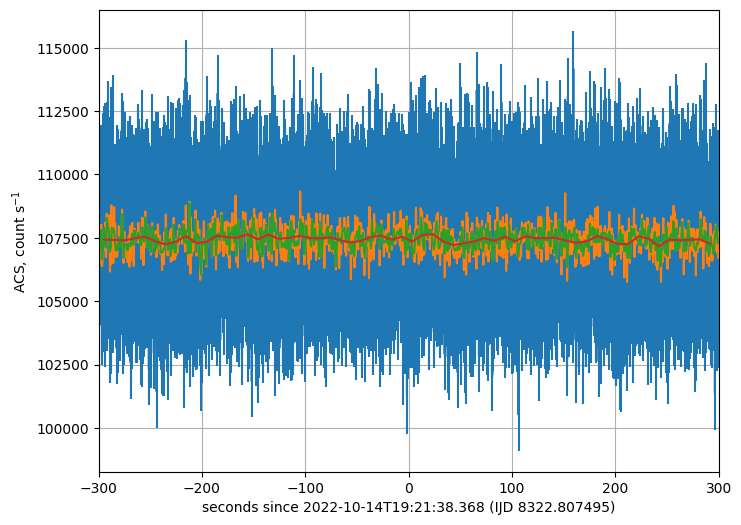

In [13]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [14]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

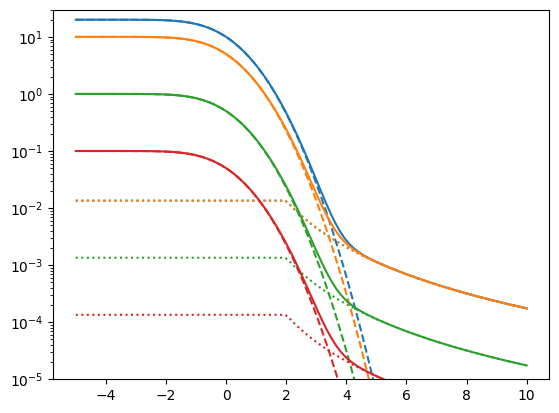

In [15]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [16]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

total lc (12000, 4)
min -0.003472220892945188
max 0.0034716493682935834
expected telapse 600.0 telapse 599.9503905710299 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
9188 3.9206112813064253 159.40041422727518
scale 0.05000000000000001 offset 0 found excesses 14
requested scale 0.1
1152 3.8749043006734554 -184.7748086467618
scale 0.10000000000000002 offset 0 found excesses 6
5035 3.7701142857295515 203.57544375874568
scale 0.10000000000000002 offset 1 found excesses 8
requested scale 0.15000000000000002
768 3.654075186172902 -184.74980838946067
scale 0.15000000000000002 offset 0 found excesses 7
2174 3.316833394548828 26.20032780105248
scale 0.15000000000000002 offset 1 found excesses 3
767 3.482732548628709 -184.79980822303332
scale 0.15000000000000002 offset 2 found excesses 4
requested scale 0.2
854 3.527696789854768 -129.1247711837059
scale 0.20000000000000004 offset 0 found excesses 5
2470 3.452942985314336 194.1254359233426
scale 0.20000000000000004 offse

{'localfar_s': 1.9205684850411435,
 'scale': 1.0,
 'summary_scale': {'scale_s': 1.0000000000000002,
  'meanrate': 107440.23706176959,
  'maxrate': 108853.99999999997,
  'stdvar': 375.3981666638844,
  'meanerr': 327.7807759185544,
  'excvar': 1.1452720667094942,
  'maxsnr': 3.741499813037911,
  'maxsnr_t': -212.17482622596435,
  'localfar': 0.05478613146485534,
  'localfar_s': 1.9205684850411435,
  'excesses': [{'snr': 3.741499813037911,
    'rel_s_scale': -212.17482622596435,
    'rate': 108853.99999999997,
    'rate_err': 329.93029566864567,
    'rate_overbkg': 1413.7629382303858,
    'FAP': 0.9672643300872222}]}}

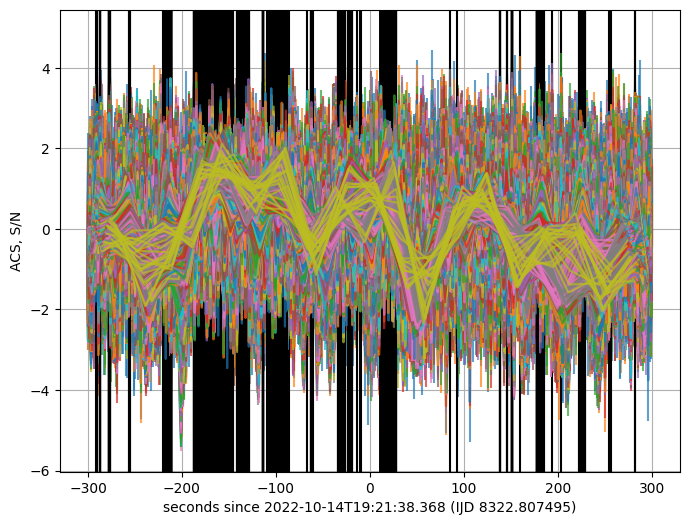

In [17]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    for ascale in timescales:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))
            
            

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r=pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

In [18]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

1.0000000000000002 5 3.5561975288406265 11.725318453100044 0.07439426106321696
new group
1.1500000000000001 12 3.3459176574629943 11.650318266449334 0.10134724725958784
to group 11.725318453100044
1.0000000000000002 6 3.3896244576694086 11.775318551226519 0.10648239724468928
to group 11.725318453100044
2.2500000000000004 15 3.0512752202753157 12.350318654207513 0.11557479380857362
to group 11.725318453100044
1.3000000000000003 10 3.20294285754247 11.825318462573565 0.12907133977971733
to group 11.725318453100044
2.2500000000000004 14 3.0077719194001635 12.300318611087278 0.1292924573409136
to group 11.725318453100044
0.7500000000000001 6 3.419598368997893 11.90031883190386 0.13412381161763173
to group 11.725318453100044
1.3000000000000003 9 3.154238580609055 11.77531841945333 0.14557711274657723
to group 11.725318453100044
1.2500000000000002 0 3.1656580066358626 11.850318524753675 0.1479473749320978
to group 11.725318453100044
1.3000000000000003 11 3.093270015255122 11.8753185056938 0.

In [19]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print("%4.2lg"%i['scale'], "%5.2lg"%i['excess']['snr'], "%6.3lg"%i['excess']['rel_s_scale'], "%7.5lg"%i['excess']['FAP'])

   1   3.6   11.7 0.074394
 2.6   3.5   -150 0.43542
 3.3   3.3   -159 0.56713
   1   3.7   -212 0.96726
 1.9     3   -102  1.2028
0.55   3.5   -105  1.3737
   2   3.1   -181  1.7932
0.15   3.3   26.2  1.8719
0.25   3.7   -129  2.4302
0.15   3.2  -26.2  2.5045
0.25   3.6   -168  3.9242
 0.4   3.3    152  3.9927
0.25   3.2  -62.1  4.0082
 1.3   3.1   -277  4.2572
 0.1   3.2    -30  4.6017
 0.4   3.2    138  4.8766
 0.1   3.1   31.6  6.3622
0.05   3.9    159  6.5696
 0.1   3.9   -185  6.9232
 0.2   3.5    194  7.6254
0.05   3.4     66  7.8326
0.25     3   85.9  7.8585
 0.3   3.2   -171   8.016
 0.1   3.8    204  8.8729
0.15   3.5    181  9.1826
 0.2     3  -82.1  9.9017
 0.1   3.1   50.5  10.028
0.05   3.1  -31.3  10.537
 0.2   3.1   -130  11.564
0.05   3.2     50  12.037
0.05   3.5   -132  12.338
0.05   3.7   -216  13.172
0.05   3.4   -111  15.889
 0.1   3.1  -93.8  15.916
0.15   3.2    183  19.461
0.05   3.2   89.8  23.096
0.05   3.3    154  26.717
0.05   3.1  -92.4  29.079
 0.1   3.1 

In [20]:
import json

len(json.dumps(grouped_excesses))

10059

In [21]:
summary['ACS']['best']

{'localfar_s': 1.9205684850411435,
 'scale': 1.0,
 'summary_scale': {'scale_s': 1.0000000000000002,
  'meanrate': 107440.23706176959,
  'maxrate': 108853.99999999997,
  'stdvar': 375.3981666638844,
  'meanerr': 327.7807759185544,
  'excvar': 1.1452720667094942,
  'maxsnr': 3.741499813037911,
  'maxsnr_t': -212.17482622596435,
  'localfar': 0.05478613146485534,
  'localfar_s': 1.9205684850411435,
  'excesses': [{'snr': 3.741499813037911,
    'rel_s_scale': -212.17482622596435,
    'rate': 108853.99999999997,
    'rate_err': 329.93029566864567,
    'rate_overbkg': 1413.7629382303858,
    'FAP': 0.9672643300872222}]}}

In [22]:
summary['ACS']['s_8']

{0: {'scale_s': 8.000000000000002,
  'meanrate': 107439.59999999999,
  'maxrate': 107725.99999999997,
  'stdvar': 147.28630848339796,
  'meanerr': 115.88766112058694,
  'excvar': 1.2709403836370392,
  'maxsnr': 1.9419254817750915,
  'maxsnr_t': -160.02479239425156,
  'localfar': 1.9554795781803247,
  'localfar_s': 0,
  'excesses': []},
 'best': {'localfar_s': 0.11668228974790205,
  'scale': 8.0,
  'summary_scale': {'scale_s': 8.000000000000002,
   'meanrate': 107439.73648648648,
   'maxrate': 107758.49999999997,
   'stdvar': 141.52987037822382,
   'meanerr': 115.88773472982724,
   'excvar': 1.221267036655578,
   'maxsnr': 2.2489365087796,
   'maxsnr_t': 19.37532303883927,
   'localfar': 0.907111825132188,
   'localfar_s': 0.11668228974790205,
   'excesses': []}},
 4: {'scale_s': 8.000000000000002,
  'meanrate': 107441.22297297296,
  'maxrate': 107695.49999999997,
  'stdvar': 148.35274325640887,
  'meanerr': 115.88853641159517,
  'excvar': 1.2801330299790161,
  'maxsnr': 1.7119782259252

In [23]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

0.05 1.134
0.1 1.136
0.15 1.141
0.2 1.156
0.25 1.152
0.3 1.169
0.35 1.174
0.4 1.162
0.45 1.153
0.5 1.145
0.55 1.147
0.6 1.146
0.65 1.154
0.7 1.175
0.75 1.159
0.8 1.168
0.85 1.129
0.9  1.14
0.95 1.176
1 1.145
1.1 1.149
1.15  1.16
1.25  1.15
1.3 1.139
1.4 1.164
1.5 1.137
1.6 1.132
1.7 1.155
1.85 1.145
1.95 1.186
2 1.135
2.1 1.159
2.25 1.163
2.4 1.128
2.5 1.198
2.55 1.175
2.7 1.196
2.9 1.194
3 1.163
3.1 1.168
3.3   1.2
3.5 1.148
3.55 1.184
3.75 1.241
4  1.23
4.3 1.193
4.5 1.252
4.6 1.252
4.9 1.238
5 1.196
5.2 1.223
5.5 1.233
5.55 1.179
5.95 1.192
6 1.223
6.35 1.296
6.5 1.271
6.75 1.269
7 1.211
7.2 1.124
7.5 1.301
7.7 1.273
8 1.221
8.2 1.255
8.5 1.272
8.75 1.229
9 1.297
9.35 1.311
9.5  1.32
10 1.214
10.5  1.29
10.65 1.352
11 1.182
11.35 1.298
11.5 1.443
12 1.204
12.1  1.19
12.5 1.224
12.95 1.245
13 1.259
13.5 1.279
13.8 1.298
14 1.322
14.5 1.283
14.7 1.259
15 1.238
15.5 1.313
15.7 1.243
16 1.339
16.5 1.237
16.75 1.137
17 1.194
17.5 1.283
17.85  1.33
18 1.328
18.5 1.214
19 1.134
19.05 1.135

total lc (12000, 4)
min -0.003472220892945188
max 0.0034716493682935834
total lc (12000, 4)
min -0.003472220892945188
max 0.0034716493682935834
{'scale': 1.0000000000000002, 'offset': 5, 'excess': {'snr': 3.5561975288406265, 'rel_s_scale': 11.725318453100044, 'rate': 108803.99999999997, 'rate_err': 329.85451338431005, 'rate_overbkg': 1363.609348914848, 'FAP': 0.07439426106321696}}
(-2.0, 2.0)
total lc (12000, 4)
min -0.003472220892945188
max 0.0034716493682935834
{'scale': 1.0000000000000002, 'offset': 5, 'excess': {'snr': 3.5561975288406265, 'rel_s_scale': 11.725318453100044, 'rate': 108803.99999999997, 'rate_err': 329.85451338431005, 'rate_overbkg': 1363.609348914848, 'FAP': 0.07439426106321696}}
(-2.0, 2.0)
{'scale': 2.5500000000000007, 'offset': 7, 'excess': {'snr': 3.4823326640930223, 'rel_s_scale': -150.4997863649966, 'rate': 108283.13725490193, 'rate_err': 206.0678902548361, 'rate_overbkg': 843.1005423446186, 'FAP': 0.43541522050863507}}
(-2.0, 2.0)
{'scale': 3.3000000000000007,

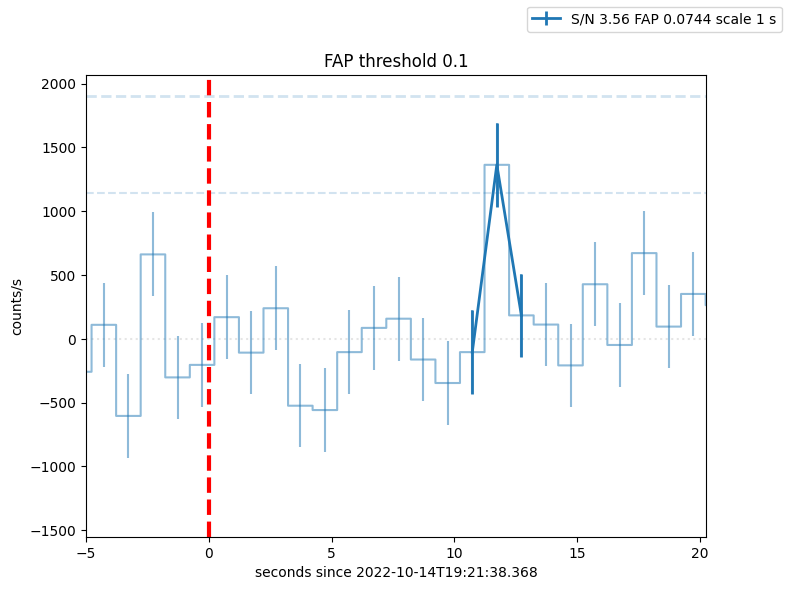

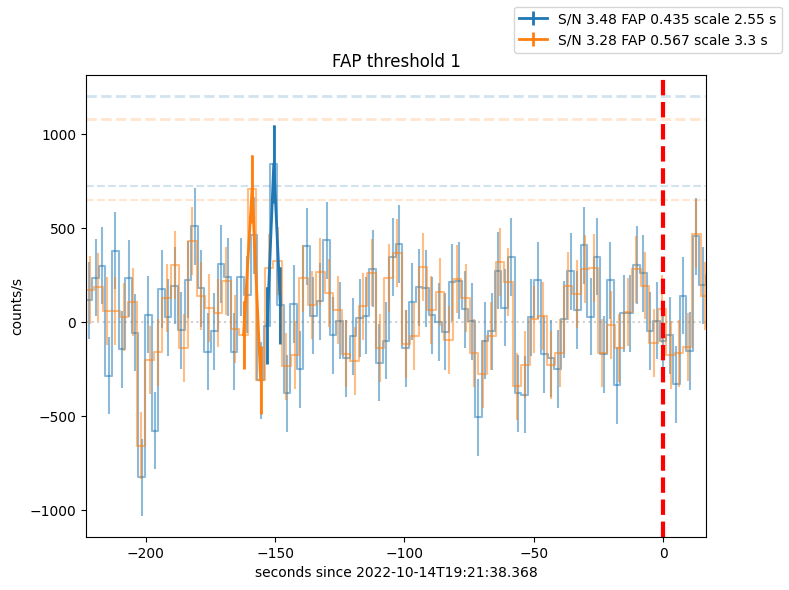

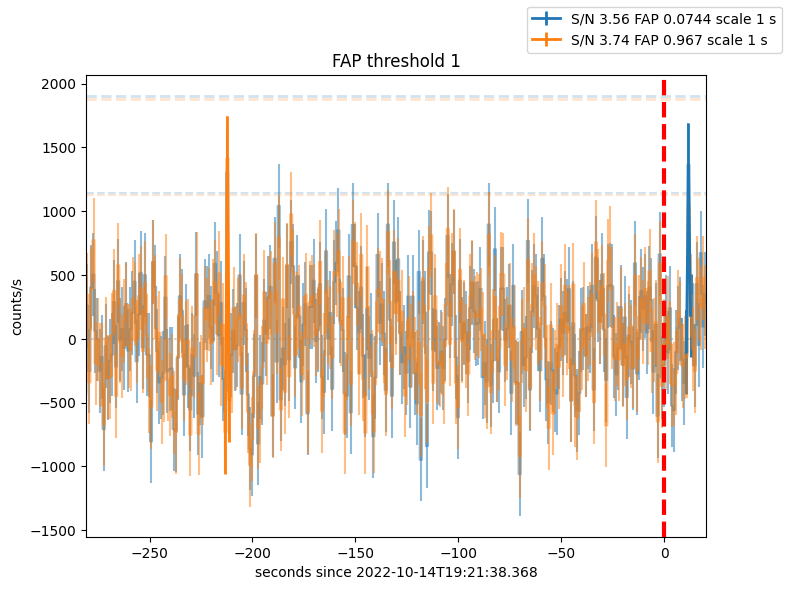

In [24]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






axes [<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >] <class 'numpy.ndarray'>


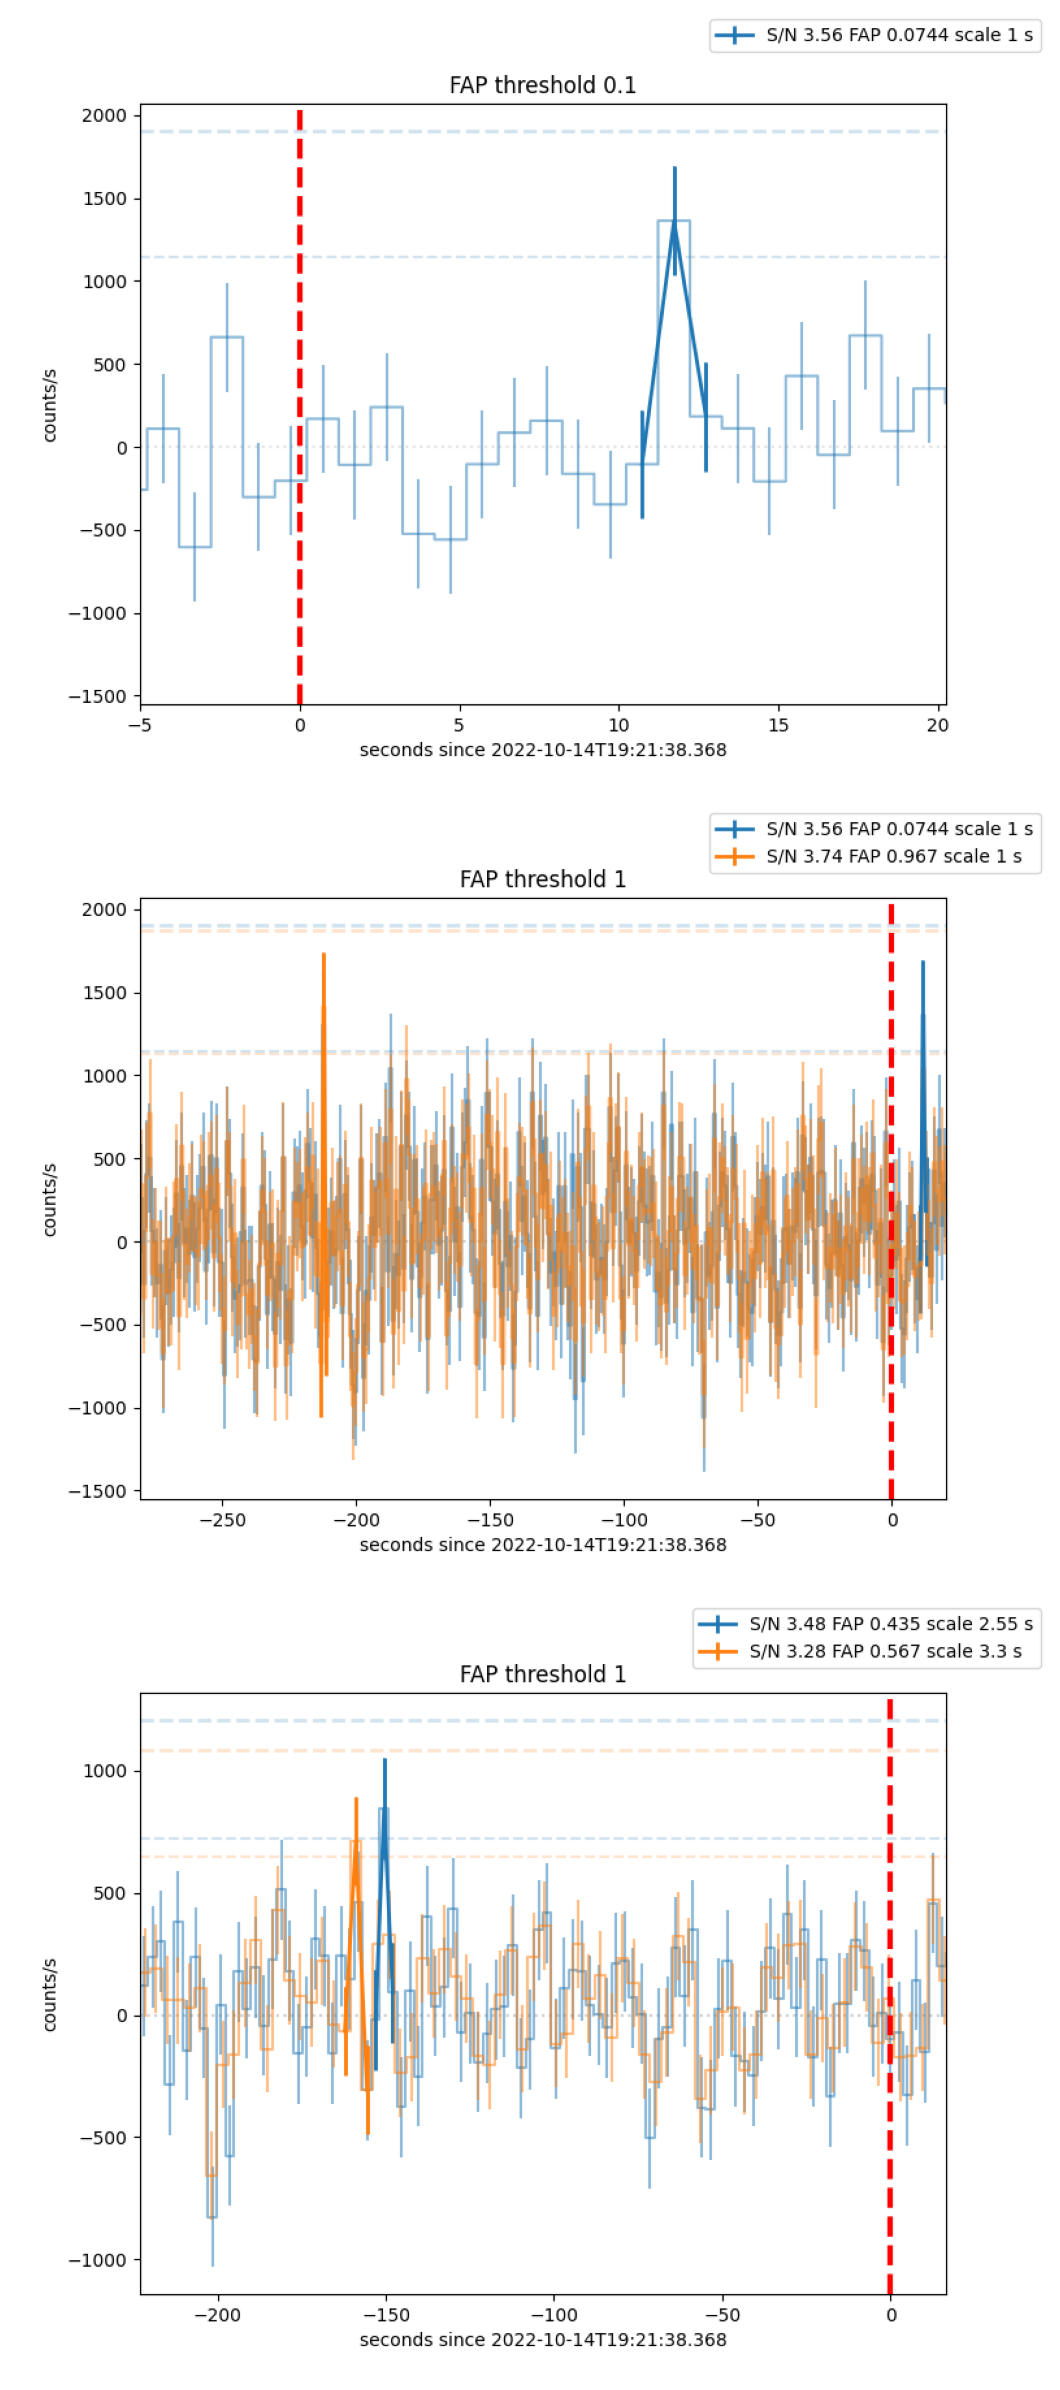

In [25]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [26]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [27]:

summary['ACS']['s_1']['meanerr']

327.7807759185544

In [28]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary